In [1]:

import os
import pickle
import numpy as np
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

c:\Users\mmkha\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

sentence_embeddings = {}
print("Reading sentence embeddings...")
with open("D:/Coding/Freelancing/advanced ML/flickr8k.dataset-cmp9137-item1/flickr8k.cmp9137.sentence_transformers.pkl", 'rb') as f:
    data = pickle.load(f)
    for sentence, dense_vector in data.items():
        sentence_embeddings[sentence] = dense_vector
        print(sentence, dense_vector.shape)
        break
print("Done reading sentence embeddings!")


Reading sentence embeddings...
A black dog and a spotted dog are fighting (384,)
Done reading sentence embeddings!


In [3]:

class DataLoader():
    BATCH_SIZE = 20
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    SENTENCE_EMBEDDING_SHAPE = 384 
    AUTOTUNE = tf.data.AUTOTUNE
    IMAGES_PATH = "flickr8k.dataset-cmp9137-item1/flickr8k-resised"
    train_data_file =  "flickr8k.dataset-cmp9137-item1/flickr8k.TrainImages.txt"
    dev_data_file = "flickr8k.dataset-cmp9137-item1/flickr8k.DevImages.txt"
    test_data_file = "flickr8k.dataset-cmp9137-item1/flickr8k.TestImages.txt"
    sentence_embeddings_file = "D:/Coding/Freelancing/advanced ML/flickr8k.dataset-cmp9137-item1/flickr8k.cmp9137.sentence_transformers.pkl"
    sentence_embeddings = {}
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.sentence_embeddings = self.load_sentence_embeddings()
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("Done loading data...")

    def load_sentence_embeddings(self):
        sentence_embeddings = {}
        print("Reading sentence embeddings...")
        with open(self.sentence_embeddings_file, 'rb') as f:
            data = pickle.load(f)
            for sentence, dense_vector in data.items():
                sentence_embeddings[sentence] = dense_vector
        print("Done reading sentence embeddings!")
        return sentence_embeddings

    def process_input(self, img_path, dense_vector, text, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255
        features = {}
        features["image_input"] = img
        features["text_embedding"] = dense_vector
        features["caption"] = text
        features["file_name"] = img_path
        return features, label

    def load_classifier_data(self, data_file):
        print("Loading data from", data_file)
        image_data = []
        text_data = []
        embeddings_data = []
        label_data = []
        with open(data_file) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("\t")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())
                label = [1, 0] if raw_label == "match" else [0, 1]
                text_sentence_embedding = self.sentence_embeddings[text]
                text_sentence_embedding = tf.constant(text_sentence_embedding)
                image_data.append(img_name)
                embeddings_data.append(text_sentence_embedding)
                text_data.append(text)
                label_data.append(label)
        dataset = tf.data.Dataset.from_tensor_slices((image_data, embeddings_data, text_data, label_data))
        dataset = dataset.shuffle(self.BATCH_SIZE * 8)
        dataset = dataset.map(self.process_input, num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.BATCH_SIZE).prefetch(self.AUTOTUNE)
        return dataset

    def print_data_samples(self, dataset):
        print("Printing data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(f'Sentence embeddings: {features_batch["text_embedding"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f'Label: {label}')
        print("-----------------------------------------")



In [4]:


class Classifier(DataLoader):
    epochs = 5
    learning_rate = 0.003
    class_names = {'match', 'no-match'}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = 'ITM_Classifier-flickr'

    def __init__(self):
        super().__init__()
        self.build_classifier_model()

    def create_vision_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")
        vgg16_model = VGG16(weights='imagenet', include_top=False)
        vgg16 = vgg16_model(img_input)

        cnn_layer = layers.Flatten()(vgg16)
        outputs = self.project_embeddings(cnn_layer, num_projection_layers, projection_dims, dropout_rate)
        return img_input, outputs

    def project_embeddings(self, embeddings, num_projection_layers, projection_dims, dropout_rate):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = layers.Dense(projection_dims)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    
    def create_text_encoder(self):
            text_input = keras.Input(shape=self.SENTENCE_EMBEDDING_SHAPE, name='text_embedding')  
            outputs = text_input 
            return text_input, outputs

    def build_classifier_model(self):
        print(f'BUILDING model')
        img_input, vision_net = self.create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
        text_input, text_net = self.create_text_encoder()  
        net = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(self.num_classes, activation='softmax', name=self.classifier_model_name)(net)
        self.classifier_model = tf.keras.Model(inputs=[img_input, text_input], outputs=net)

    def train_classifier_model(self,pretrained_model_path=None,Train=True):
        print("Training model...")
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()

        loss = tf.keras.losses.BinaryCrossentropy()
        metrics = [tf.keras.metrics.BinaryAccuracy()]
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        self.classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        if pretrained_model_path and os.path.isfile(pretrained_model_path):
            self.classifier_model = tf.keras.models.load_model(pretrained_model_path)
        if not Train:
            return
        history = self.classifier_model.fit(self.train_ds,
                                            validation_data=self.val_ds,
                                            epochs=self.epochs,
                                            steps_per_epoch=steps_per_epoch)
        self.history = history

        print("Model training completed.")
        tf.keras.models.save_model(
            self.classifier_model, "trained models\model2b.h5")

    def test_classifier_model(self,pretrained_model_path=None):
        print("Testing classifier model...")
        if pretrained_model_path:
            self.classifier_model = tf.keras.models.load_model(pretrained_model_path)
        loss, accuracy = self.classifier_model.evaluate(self.test_ds)
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)

        y_true = []
        y_pred = []
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            predictions = predictions.numpy()
            y_true.extend(groundtruth)
            y_pred.extend(predictions)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        bca = balanced_accuracy_score(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        print("Balanced Classification Accuracy:", bca)

        precision = precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        recall = recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        f1 = f1_score(y_true.argmax(axis=1), y_pred.argmax(axis=1))

        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        
        from sklearn.metrics import confusion_matrix
        print("Confusion Matrix:")
        cm =confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        print(cm)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Match', 'Match'], yticklabels=['No Match', 'Match'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()




In [5]:
# Let's create an instance of the main class
classifier = Classifier()


Reading sentence embeddings...
Done reading sentence embeddings!
Loading data from flickr8k.dataset-cmp9137-item1/flickr8k.TrainImages.txt
Loading data from flickr8k.dataset-cmp9137-item1/flickr8k.DevImages.txt
Loading data from flickr8k.dataset-cmp9137-item1/flickr8k.TestImages.txt
Done loading data...
BUILDING model


In [6]:
# itm.train_classifier_model(True)
classifier.train_classifier_model("trained models\model2b.h5",True)


Training model...
Epoch 1/5


c:\Users\mmkha\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['caption', 'file_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


970/970 [==============================] - 397s 389ms/step - loss: 0.6180 - binary_accuracy: 0.6761 - val_loss: 0.6293 - val_binary_accuracy: 0.6658
Epoch 2/5
970/970 [==============================] - 343s 353ms/step - loss: 0.6172 - binary_accuracy: 0.6780 - val_loss: 0.6304 - val_binary_accuracy: 0.6692
Epoch 3/5
970/970 [==============================] - 343s 353ms/step - loss: 0.6171 - binary_accuracy: 0.6796 - val_loss: 0.6295 - val_binary_accuracy: 0.6675
Epoch 4/5
906/970 [===========================>..] - ETA: 22s - loss: 0.6172 - binary_accuracy: 0.6788

KeyboardInterrupt: 

Testing classifier model...
59/59 [==============================] - 7s 119ms/step - loss: 0.6535 - binary_accuracy: 0.6494
Test Loss: 0.653505802154541
Test Accuracy: 0.6494401097297668
Balanced Classification Accuracy: 0.6751047906595788
Precision: 0.8753993610223643
Recall: 0.6248574686431014
F1-score: 0.729208250166334
Confusion Matrix:
[[206  78]
 [329 548]]


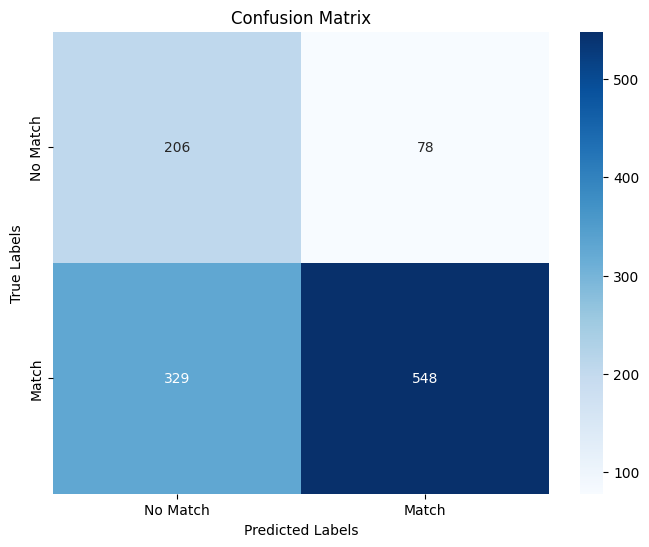

In [ ]:
classifier.test_classifier_model("trained models\model2b.h5")
